<a href="https://colab.research.google.com/github/stepanjaburek/quantum_social_science_lr/blob/main/stepan_colab_HCPC_13_1_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Social Science: PCA and Cluster Analysis of the Literature

#Setup

In [ ]:
!pip install scikit-learn-extra
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from IPython.display import display

data = pd.read_excel("/content/pdf_search_results(1).xlsx")
#data = pd.read_csv("/0_kw_analysis.csv")
metadata = pd.read_excel("/content/pdf_list(1).xlsx")

#Data cleaning

In [2]:
# Rename "Broekaert_2018" in metadata
metadata.loc[252, 'file_name'] = "Broekaert_2018_The Tacit 'Quantum' of Meeting the Aesthetic Sign; Contextualize, Entangle,2.pdf"
data.loc[252, 'filename'] = "Broekaert_2018_The Tacit 'Quantum' of Meeting the Aesthetic Sign; Contextualize, Entangle,2.pdf"
# Delete duplicit paper "Yukalov et al. - 2018 - Information processing by networks of quantum deci.pdf"
data = data.drop(1170)
# Delete paper "Yilmaz - 2017 - Quantum cognition models of ethical decision-makin.pdf" that is only present in data
data = data.drop(1166)
# Delete paper "Park_2016_Decision-making &amp quantum mechanical models of cognitive processing.pdf" that is only present in metadata
metadata = metadata.drop(892)

# Keywords

In [3]:
# Exclude authors and create df
df = data.drop(columns=[data.columns[i] for i in [1,2,4,16,30]])
# Exclude social science fields
df = df.drop(columns=df.columns[26:38])
# Possibly also Exclude "quantum" and "quantization"
df = df.drop(columns=df.columns[17:19])

# keep only papers with some non-zero values in the final columns we want to keep
df = df[df.iloc[:, 2:24].sum(axis=1) > 0]
df = df.reset_index(drop=True)

In [ ]:
[(i, list(df.keys())[i]) for i in range(len(df.keys()))]

In [ ]:
df

In [ ]:
# Or keeep only the authors
#df = data[data.columns[[1,2,4,16,30]]]

# Numbering the data for centroid extraction

In [6]:
metadata = metadata.reset_index()
metadata = metadata.rename(columns={'index': 'id'})
metadata['id'] = metadata['id'] + 1

df = df.reset_index()
df = df.rename(columns={'index': 'id'})
df['id'] = df['id'] + 1

# Scaling in the rows

In [ ]:
# create features for the pca
features = df.drop(['filename', 'id'], axis=1)
feature_names = features.columns


features = features.div(features.sum(axis=1), axis=0) # row normalization as Michael suggested, dividing the values by the sum of their row (paper)
#features = StandardScaler().fit_transform(features.T).T # Z-score standardization on transposed data to work in rows

features = pd.DataFrame(features, columns=feature_names)
features

# Scaling in the columns

In [ ]:
# create features for the pca
features = df.drop(['filename', 'id'], axis=1)
feature_names = features.columns

# scale with either z-score standardization or MinMax normalization
# features = StandardScaler().fit_transform(features) #Z-score
# features = MinMaxScaler().fit_transform(features) # MinMax

#features.iloc[:, 1:23] = (features.iloc[:, 1:23] > 0).astype(int) # binary >0
#features.iloc[:, 1:23] = (features.iloc[:, 1:23] > 4).astype(int) # binary >4

features = pd.DataFrame(features, columns=feature_names)
features

# Data analysis

#PCA

Explained variance ratio: [0.21805248 0.17690307 0.12289477 0.1014373  0.07854515 0.06598143
 0.05947673 0.04551538 0.04025369 0.03393288]


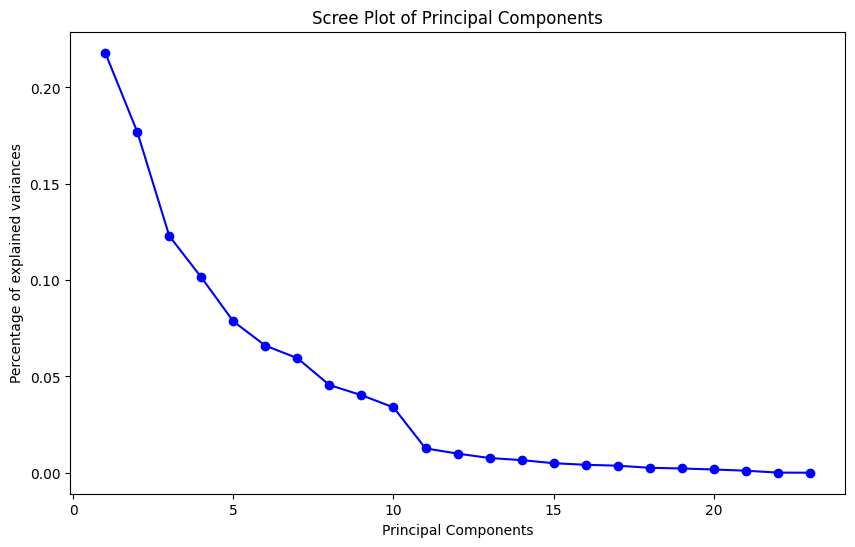

                         feature    PC   loading
entanglement        entanglement   PC1  0.825192
operator                operator   PC1 -0.536061
uncertainty          uncertainty   PC1 -0.092500
hamiltonian          hamiltonian   PC1 -0.080572
interference        interference   PC1 -0.074973
...                          ...   ...       ...
born's rule          born's rule  PC23  0.208514
complementarity  complementarity  PC23  0.208514
superposition      superposition  PC23  0.208514
wave function      wave function  PC23  0.208514
operator                operator  PC23  0.208514

[115 rows x 3 columns]
                     feature   PC   loading
entanglement    entanglement  PC1  0.825192
interference    interference  PC1 -0.074973
hamiltonian      hamiltonian  PC1 -0.080572
uncertainty      uncertainty  PC1 -0.092500
operator            operator  PC1 -0.536061
operator            operator  PC2  0.693404
entanglement    entanglement  PC2  0.384714
superposition  superposition  PC2 -0

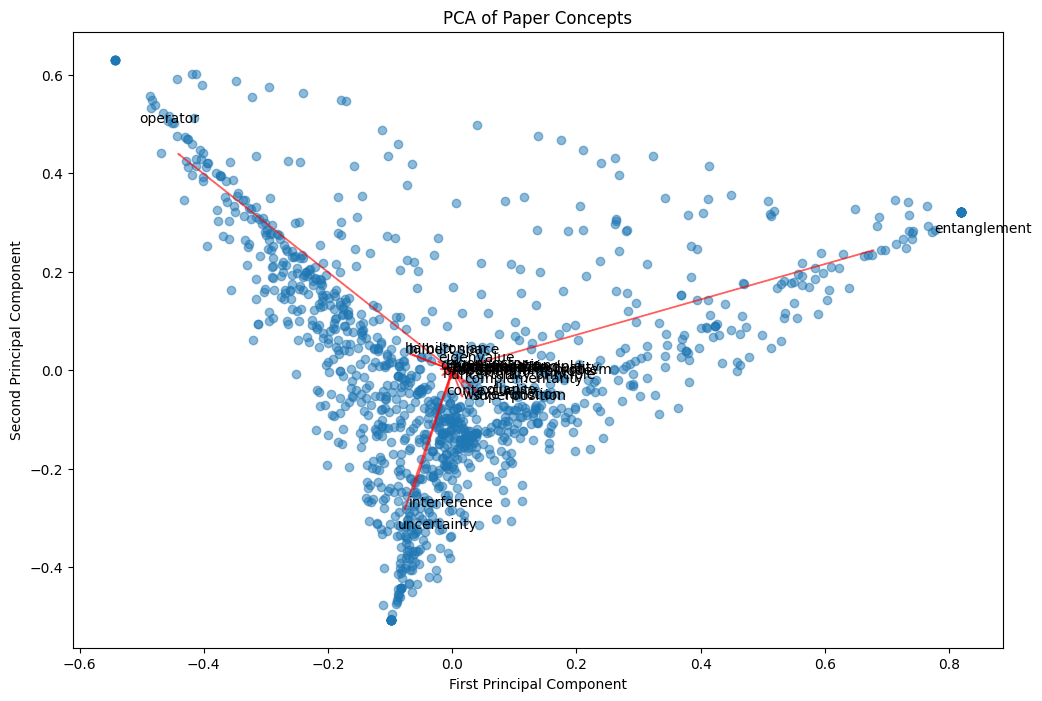

,feature,PC,loading
entanglement,entanglement,PC1,0.825192
interference,interference,PC1,-0.074973
hamiltonian,hamiltonian,PC1,-0.080572
uncertainty,uncertainty,PC1,-0.092500
operator,operator,PC1,-0.536061
operator,operator,PC2,0.693404
entanglement,entanglement,PC2,0.384714
superposition,superposition,PC2,-0.081865
interference,interference,PC2,-0.380147
uncertainty,uncertainty,PC2,-0.444301


In [8]:
pca = PCA()
pca_result = pca.fit_transform(features)
print("Explained variance ratio:", pca.explained_variance_ratio_[:10])

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_, 'bo-')
plt.title('Scree Plot of Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Percentage of explained variances')
plt.show()

# Feature importance in components
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=features.columns
)

# Top 5 features per component
top_loadings = pd.DataFrame()
for pc in loadings.columns:
    top_5 = pd.DataFrame({
        'feature': loadings.index,
        'PC': pc,
        'loading': loadings[pc]
    })

    top_5 = top_5.reindex(top_5['loading'].abs().sort_values(ascending=False).index)
    top_5 = top_5.head(5)
    top_loadings = pd.concat([top_loadings, top_5])

print(top_loadings)

# PC1 and 2
pc12_loadings = top_loadings[top_loadings['PC'].isin(['PC1', 'PC2', 'PC3', 'PC4'])]
pc12_loadings = pc12_loadings.sort_values(['PC', 'loading'],
                                         ascending=[True, False])
print(pc12_loadings)

# PCA biplot
plt.figure(figsize=(12, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)

for i, feature in enumerate(features.columns):
    plt.arrow(0, 0,
              pca.components_[0, i]*max(abs(pca_result[:, 0])),
              pca.components_[1, i]*max(abs(pca_result[:, 1])),
              color='r', alpha=0.5)
    plt.text(pca.components_[0, i]*max(abs(pca_result[:, 0]))*1.15,
             pca.components_[1, i]*max(abs(pca_result[:, 1]))*1.15,
             feature)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Paper Concepts')
plt.show()
display(pc12_loadings)

How many PCs do we want? Literature says probably a sum between 80-90% of explained variance

Number of components needed to explain 80% of variance: 7


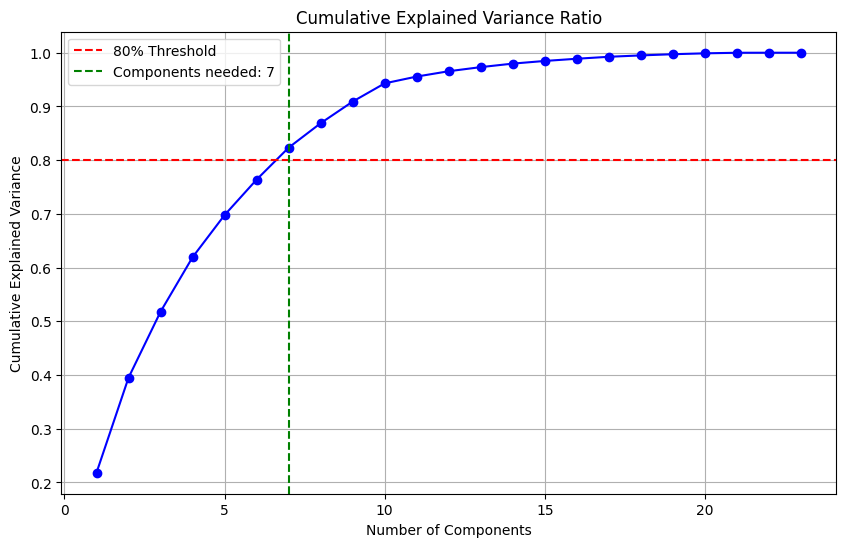


Cumulative explained variance for first 10 components:
Components 1-1: 0.218
Components 1-2: 0.395
Components 1-3: 0.518
Components 1-4: 0.619
Components 1-5: 0.698
Components 1-6: 0.764
Components 1-7: 0.823
Components 1-8: 0.869
Components 1-9: 0.909
Components 1-10: 0.943


In [9]:
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
# Find number of components needed for 80% variance (we can change this)
n_components_80 = np.argmax(cumulative_variance_ratio >= 0.8) + 1

print(f"Number of components needed to explain 80% of variance: {n_components_80}")

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1),
         cumulative_variance_ratio,
         'bo-')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
plt.axvline(x=n_components_80, color='g', linestyle='--',
            label=f'Components needed: {n_components_80}')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

print("\nCumulative explained variance for first 10 components:")
for i in range(10):
    print(f"Components 1-{i+1}: {cumulative_variance_ratio[i]:.3f}")

# Hierarchical Clustering on Principal Components (HCPC)

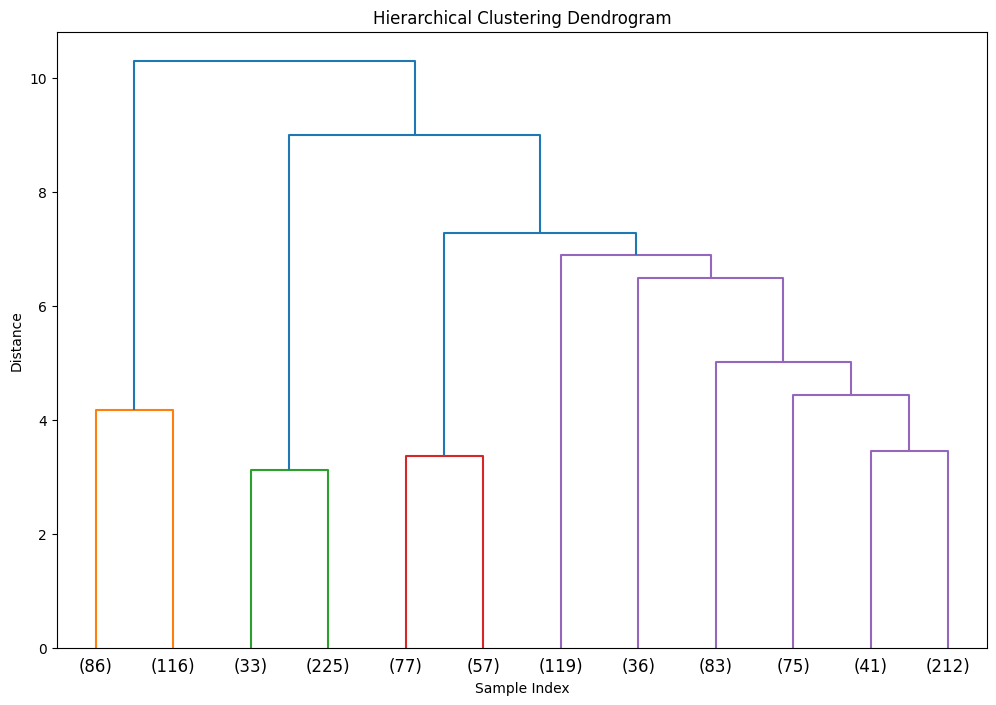

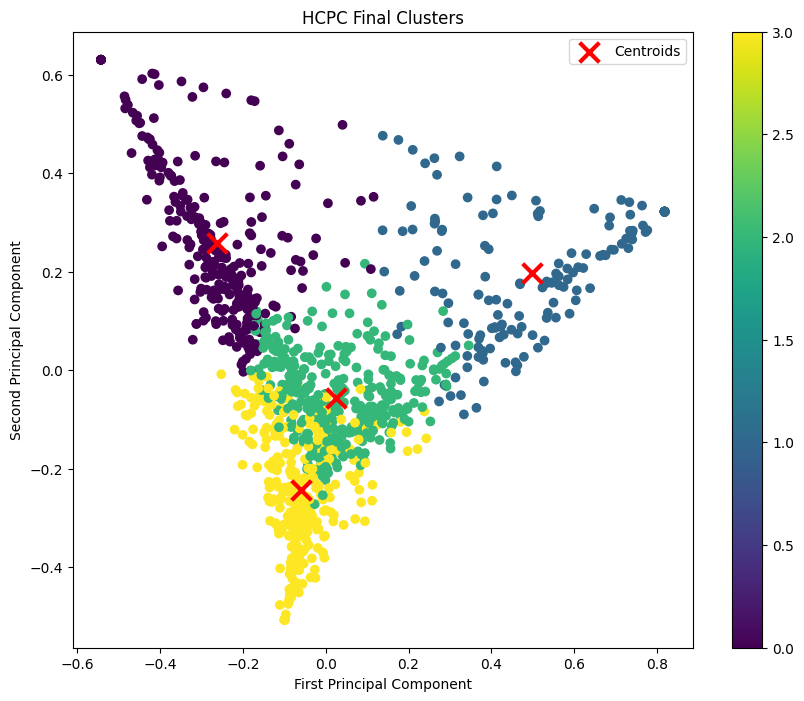

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# 1. Define how many PCs to use
n_components = 7 # I think we should use between 7 and 9 based on the PCA
selected_components = pca_result[:, :n_components]

# 2. Hierarchical clustering uisng Ward
linked = linkage(selected_components, method='ward') # the methods can be different. Ward method is the one we use in Ipsos and seemingly the typical choice in the literature

# Plot dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linked, truncate_mode='lastp', p=12)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# 3. Get initial clusters from hierarchical clustering # optional step though, we dont really need them
n_clusters = 4
hc_labels = fcluster(linked, n_clusters, criterion='maxclust')

# 4. K-means to finalize things
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(selected_components)
final_labels = kmeans.labels_


# Visualize final clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1],
                     c=final_labels, cmap='viridis')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
           c='red', marker='x', s=200, linewidths=3, label='Centroids')
plt.colorbar(scatter)
plt.title('HCPC Final Clusters')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.show()

K-Medoids as an alternative ending

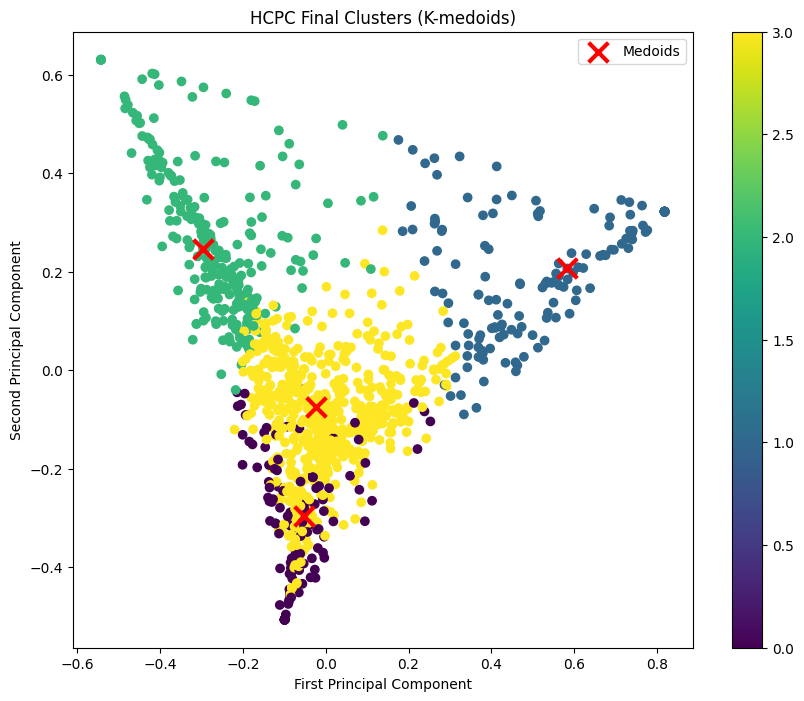

In [11]:
kmedoids = KMedoids(n_clusters=n_clusters,
                    random_state=42,
                    metric='euclidean')
kmedoids.fit(selected_components)
final_labels = kmedoids.labels_

# Visualize final clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1],
                     c=final_labels, cmap='viridis')

# Get medoid locations in PCA space
medoid_indices = kmedoids.medoid_indices_
medoid_locations = pca_result[medoid_indices]

# Plot medoids
plt.scatter(medoid_locations[:, 0], medoid_locations[:, 1],
           c='red', marker='x', s=200, linewidths=3, label='Medoids')

plt.colorbar(scatter)
plt.title('HCPC Final Clusters (K-medoids)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.show()

# Get central papers from the HCPC

In [12]:
centroids_list = []
for i in range(n_clusters):
    distances = np.sum((selected_components - kmeans.cluster_centers_[i])**2, axis=1)
    top_indices = np.argsort(distances)[:10]  # specify N of papers

    cluster_papers = pd.DataFrame({
        'cluster': [i + 1] * 10,
        'rank': range(1, 11),
        'centroid_id': df['id'].iloc[top_indices].values,
        'distance': distances[top_indices]
    })
    centroids_list.append(cluster_papers)

centroids = pd.concat(centroids_list, ignore_index=True)
centerpapers = pd.merge(centroids, metadata, left_on='centroid_id', right_on='id', how='left')
centerpapers.to_csv('means_center_papers_hcpc.csv', index=False)

In [13]:
centroids_list = []
for i in range(n_clusters):
    medoid_point = selected_components[kmedoids.medoid_indices_[i]]
    distances = np.sum((selected_components - medoid_point)**2, axis=1)
    top_indices = np.argsort(distances)[:10]  # specify N of papers

    cluster_papers = pd.DataFrame({
        'cluster': [i + 1] * 10,
        'rank': range(1, 11),
        'centroid_id': df['id'].iloc[top_indices].values,
        'distance': distances[top_indices]
    })
    centroids_list.append(cluster_papers)

centroids = pd.concat(centroids_list, ignore_index=True)
centerpapers = pd.merge(centroids, metadata, left_on='centroid_id', right_on='id', how='left')
centerpapers.to_csv('medoids_center_papers_hcpc.csv', index=False)